# A simple library for building System Dynamics and Agent Based models in Python

To make our business prototyping toolkit even more powerful, we've added some functionality that let's us build System Dynamics models and Agent-based models directly in Python, even allowing us to mix the two and create "hybrid" simulation models.

This new functionality seamlessly integrates with the rest of BPTK PY, so you can use all the known plotting functions. 

This is useful for several reasons:

* …

## Building the Simple Project Management Model directly in Python

So now let's re-create our simple project management model directly in Python - this post assumes you know about System Dynamics and about our simple project management model. You can learn more about both in our step-by-step tutorial.

First, we need to import the library and in particular the SD function library, which we need to define our model equations. Because the library contains functions such as `min` and `max`, which are also part of the Python standard library, we import the SD function library with the prefix `sd`.

In [1]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

Next we create a model using the model class. Our model will contain all our model elements such as stocks, flows, converters and constants.

In [2]:
model = Model(starttime=0,stoptime=120,dt=1,name='SimpleProjectManagament_scenario80')

Creating model elements is easy. You call the right "element creator function" and give the element a meaningful name.

Our convention is to use the camel casing naming convention for the model elements and to create variables for the elements that carry the same name.

Let's create a stock called "openTasks".

In [3]:
openTasks = model.stock("openTasks")

By default stocks have an initial value of 0 – we would like `openTasks`to start at 100, so we change this.

In [4]:
openTasks.initial_value = 100

In [5]:
closedTasks = model.stock("closedTasks")

Let's create the other model variables, before we start defining the model equations.

In [6]:
staff = model.stock("staff")
completionRate = model.flow("completionRate")
currentTime = model.converter("currentTime")
remainingTime = model.converter("remainingTime")
schedulePressure = model.converter("schedulePressure")
productivity = model.converter("productivity")
deadline = model.constant("deadline")
effortPerTask = model.constant("effortPerTask")
initialStaff = model.constant("initialStaff")
initialOpenTasks = model.constant("initialOpenTasks")

Note that we differentiate between constants and converters - this isn't strictly necessary, but it makes it easier to check the model for errors.

Now let's initialize the stocks:

In [7]:
closedTasks.initial_value = 0 # not really necessary, but I like to be explicit
staff.initial_value = initialStaff # I prefer using constants to initialize non-zero stocks
openTasks.initial_value = initialOpenTasks 

Now that we have set up the variables, we can define the equations for each variable. This is really easy: each model variable has an `equation` property, the equation itself is written much like you would in a visual modeling environment, using the other variables as necessary.

Defining constants is particularly easy:

In [8]:
deadline.equation = 100
effortPerTask.equation = 1
initialStaff.equation = 1
initialOpenTasks.equation = 80

The `currentTime` variable tracks the simulation time, which is captured by the `time` function in the SD function library.

In [9]:
currentTime.equation=sd.time()

As soon as we define an equation, a corresponding Python function is autoamtically created for us - as a modeller you don't need to worry about this, we mainly use this for debugging purposes.

We story the function as a Python lambda function but also store it in string format, you can look at this in the `function_string` property:

In [10]:
currentTime.function_string

'lambda model, t: t'

The equation for remaningTime is slightly more interesting - you can see that defining equations is very intuitive.

In [11]:
remainingTime.equation = deadline - currentTime

The equations for the stocks are also really simple - they just contain the inflows (with a positive sign) and the outlflows (with a negative sign). 

In this simple model, the `openTasks` only have an outflow (defined by the `completionRate`) and the `closedTasks` only have an inflow (also defined by the `completionRate`):

In [12]:
openTasks.equation = -completionRate

In [13]:
closedTasks.equation = completionRate

The `schedulePressure`is a much more exciting equation use the min and max functions from the SD function library.

But still the equation is really easy to read:

In [14]:
schedulePressure.equation = sd.min((openTasks*effortPerTask)/(staff*sd.max(remainingTime,1)),2.5)

The productivty in our model is defined by a non-linear relationship. We capture this using a table that we store in a Python list. To be able to modify the points later using a strategy, we store it within the model and link to it in the productivity equation:

In [15]:
model.points["productivity"] = [ [0,0.4],[0.25,0.444],[0.5,0.506],[0.75,0.594],[1,1],[1.25,1.119],[1.5,1.1625],[1.75,1.2125],[2,1.2375],[2.25,1.245],[2.5,1.25] ]

The productivity equation is the defined via a lookup function:

In [16]:
productivity.equation = sd.lookup(schedulePressure,"productivity")

The last equation we need to define is that of the completion rate. As it may never get negative, we have to use a conjunction of the max and min operator:

In [17]:
completionRate.equation = sd.max(0, sd.min(openTasks, staff*(productivity/effortPerTask)))

Now that we have defined all necessary equations, we are ready to run the model. The easist way is to evaluate a model variable at a particular timestep - this approach is particularly useful if you are building the model interactively (e.g. in a Jupyter notebook) and you want to test intermediate results.

In [18]:
closedTasks(100)

79.99700229153399

We can now play with different settings for the deadline:

In [19]:
deadline.equation = 120

In [20]:
closedTasks(100)

62.41586962739367

In [21]:
deadline.equation=80

In [22]:
closedTasks(80)

80.0

Of course you can also plot the variables in a graph straight away using the element's  ``plot()`` method. Optionally, we can use the ``starttime / stoptime / dt`` parameters to override the model parameters.

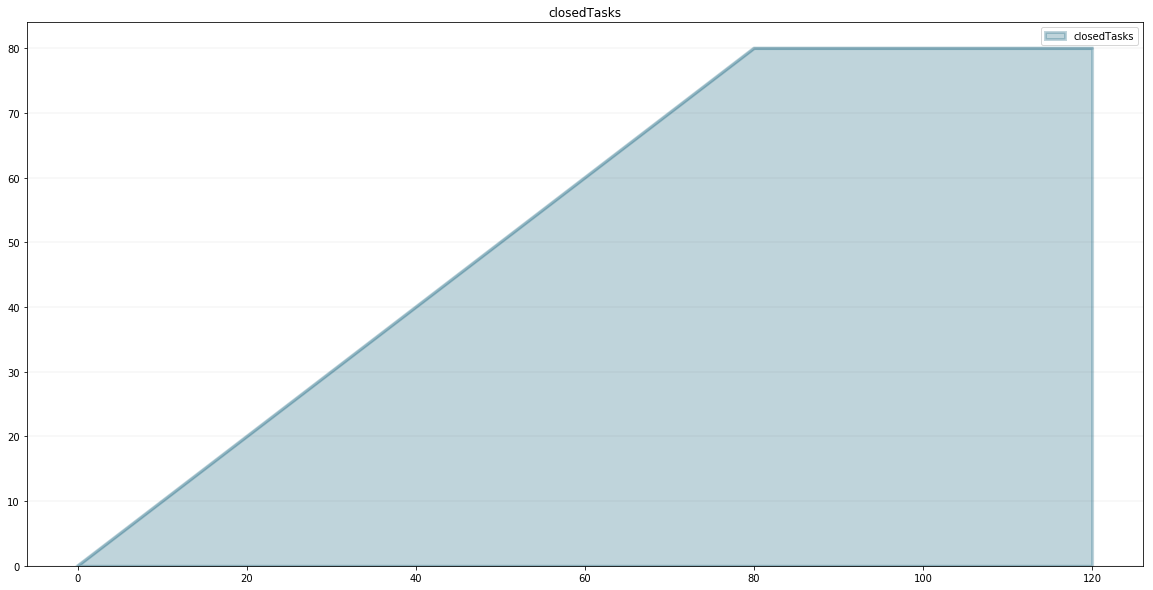

In [23]:
closedTasks.plot(starttime=0,stoptime=120,dt=1)

To integrate the custom simulation scenario into the Business Prototyping Toolkit and simulate along with other scenarios, just register the scenario with BPTK_Py. 

The benefit is obvious - you can now compare the scenario with other System Dynamics models from Stella or your Agent based models.

First we need to instantiate ``BPTK``:


In [24]:
import BPTK_Py
bptk = BPTK_Py.bptk()


And then define the scenarios in the usual way using dictionaries:

In [25]:
scenarios = {
    
    "scenario100_strategy":{
        "constants": {
            "initialOpenTasks" : 100
        },
        "strategy": {
            10: {
                "deadline" : 150
            },
            20 : {
                "deadline" : 200
            },
            30 : {
                "deadline" : 80
            }
        } 
    },
    "scenario100": {
        "constants" : {
            "initialOpenTasks" : 100
        }
    },
    "scenario80": {
        "constants": {
            "initialOpenTasks": 80
        }
    },
    "scenario120": {
        "constants": {
            "initialOpenTasks" : 120
        }
    }
    
}

But that is not enough. ``BPTK`` also needs to know for which scenario manager to create the scenarios. Furthermore the scenario manager stores the model.
Internally, the manager creates a copy of the ``model`` for each scenario to avoid changes on one  scenario modifying another.

The fields are the same as in the JSON files, with the difference that ``model`` stores the model and not a link to the python file

In [36]:
scenario_manager = {
    "smSimpleProjectManagement_SelfMade":{
    
    "model": model,
    "base_constants": {
          "deadline": 100,
          "initialOpenTasks": 100,

    },
    "base_points":{
            "productivity": [ [0,10]] # Test: Setting points to another value
    },
    "scenarios": scenarios
        
    
    },
    "smSimple2": {
        "model" : model,
        "scenarios": {
            "base" : {}
        }
    }
    
}

And now we can just register and plot:

In [37]:
bptk.register_model(model, dictionary=scenario_manager)

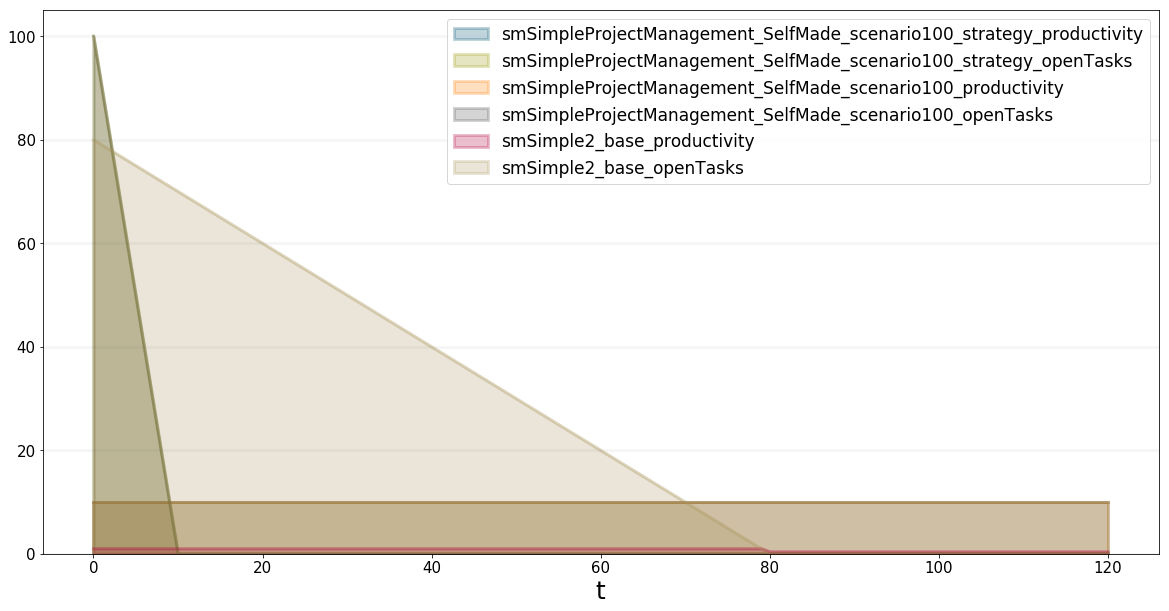

In [40]:
bptk.reset_simulation_model(scenario="scenario100_strategy",scenario_manager="smSimpleProjectManagement_SelfMade")

bptk.plot_scenarios(scenarios=["scenario100","scenario100_strategy","base"],scenario_managers=["smSimpleProjectManagement_SelfMade","smSimple2"],equations=["productivity","openTasks"],strategy=False)